In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy.integrate as spint
import jax.scipy.integrate as jspint
import matplotlib.pyplot as plt
import scipy as sp
import functools
import time
from jax.scipy.signal import convolve as spconvolve

from tqdm import tqdm

seed = 1
key = jax.random.PRNGKey(seed)
#jax.devices()

This runs Newton's method to generate the m function, along a curve stepping from infinity to $xs$ through the upper half plane.

$F(m)=1$

Initialization is at $m_0$

$F(m) \approx F(m_0) + F'(m_0)*(m-m_0) = 1$

Now set 

$m = m_0 + \frac{1-F(m_0)}{F'(m_0)}$

We apply this to the MDE, i.e.

$F(m) = m + \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}m}{j^{-2\alpha}m - z}$

$F'(m) 
= 1 + \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}}{j^{-2\alpha}m - z}-\frac{j^{-4\alpha}m}{(j^{-2\alpha}m - z)^2}= 1 - \frac{1}{d}\sum_{j=1}^v \frac{j^{-2\alpha}z}{(j^{-2\alpha}m - z)^2}$

In [2]:
def jax_gen_m_batched(v,d, alpha, xs,
                eta = -6, 
                eta0 = 6.0, 
                etasteps=50,
                batches = 100,
                zbatch=1000):
    """Generate the powerlaw m by newton's method

    
    Parameters
    ----------
    v,d,alpha : floats
        parameters of the model
    xs : vector
        The vector of x-positions at which to estimate the spectrum.  Complex is also possible.
    eta : float
        Error tolerance

    Returns
    -------
    m_Lambda: vector
        m_Lambda evaluated at xs.
    """
    #if zbatch > 0:
    #    xsplit = jnp.split(xs,jnp.arange(1,len(xs)//zbatch,1)*zbatch)
    #    ms = jnp.concatenate( [jax_gen_m_batched(v,d,alpha,x,eta,eta0,etasteps,batches,zbatch=0) for x in xsplit] )
    #    return ms
    v=jnp.int32(v)
    d=jnp.complex64(d)
    xs=jnp.complex64(xs)
    xsplit = jnp.split(xs,jnp.arange(1,len(xs)//zbatch,1)*zbatch)
    

    #print("xs length = {}".format(len(xs)))

    js=jnp.arange(1,v+1,1,dtype=jnp.complex64)**(-2.0*alpha)
    jt=jnp.reshape(js,(batches,-1))
    onesjtslice=jnp.ones_like(jt)[0]        

    def mup_single(m,z):
        m1 = m 
        F=m1
        Fprime=jnp.ones_like(m1,dtype=jnp.complex64)
        for j in range(batches):
            denom = (jnp.outer(jt[j],m1) - jnp.outer(onesjtslice,z))
            F += (1.0/d)*jnp.sum(jnp.outer(jt[j],m1)/denom,axis=0)
            Fprime -= (1.0/d)*jnp.sum(jnp.outer(jt[j],z)/(denom**2),axis=0)
        return (-F + 1.0)/Fprime + m1
        #return 0.1*jnp.where(mask, m1, newm1)+0.9*m1
        
#    mup_single = jax.jit(mup_single, static_argnums=(0,1))

    def mup_scanner(ms,z,x):
        #mups = lambda m : mup_single(m,z*1.0j+xs)
        return mup_single(ms,z*1.0j+x), False
    
    #mup_scanner = jax.jit(mup_scanner, static_argnums=(0,1))
    mup_scannerjit =  jax.jit(mup_scanner)

    etas = jnp.logspace(eta0,eta,num = etasteps)
    ms = jnp.concatenate( [jax.lax.scan(lambda m,z: mup_scanner(m,z,x),jnp.ones_like(x),etas)[0] for x in xsplit] )
    #ms, _ = jax.lax.scan(mup_scanner,jnp.ones_like(xs),etas)
        
    return ms

In [3]:
def jax_gen_trace_trsolvent(v,d, alpha, beta, xs,
                err = -6.0, timeChecks = False, batches=100):
    """Generate the trace resolvent

    
    Parameters
    ----------
    v,d,alpha,beta : floats
        parameters of the model
    xs : floats
        X-values at which to return the trace-resolvent
    err : float
        Error tolerance, log scale
    timeChecks: bool
        Print times for each part

    Returns
    -------
    Volterra: vector
        values of the solution of the Volterra
    """

    eps = 10.0**(err)

    zs = xs + 1.0j*eps
   
    if timeChecks:
        print("The number of points on the spectral curve is {}".format(len(xs)))

    eta = jnp.log10(eps*(d**(-2*alpha)))
    eta0 = 6
    etasteps = jnp.int32(40 + 10*(2*alpha)*jnp.log(d))

    start=time.time()
    if timeChecks:
        print("Running the Newton generator with {} steps".format(etasteps))

    ms = jax_gen_m_batched(v,d,alpha,zs,eta,eta0,etasteps,batches)

    end = time.time()
    if timeChecks:
        print("Completed Newton in {} time".format(end-start) )
    start = end

    js=jnp.arange(1,v+1,1)**(-2.0*alpha)
    jbs=jnp.arange(1,v+1,1)**(-2.0*(alpha+beta))

    jt=jnp.reshape(js,(batches,-1))
    jbt=jnp.expand_dims(jnp.reshape(jbs,(batches,-1)),-1)
    onesjtslice=jnp.ones_like(jt)[0]

    Fmeasure = jnp.zeros_like(ms)
    Kmeasure = jnp.zeros_like(ms)

    for j in range(batches):
        Fmeasure += jnp.sum(jbt[j]/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)
        Kmeasure += jnp.sum(1.0/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)

    #Kmeasure = (1-ms)*((zs + 1.0j*(10**eta)))*d    

    #Fmeasure = Fmeasure * dzs / (jnp.pi)
    #Kmeasure = Kmeasure * dzs / (jnp.pi)

    return jnp.imag(Kmeasure) / jnp.pi

In [4]:
def jax_gen_trace_fmeasure(v,d, alpha, beta, xs,
                err = -6.0, timeChecks = False, batches=100):
    """Generate the trace resolvent

    
    Parameters
    ----------
    v,d,alpha,beta : floats
        parameters of the model
    xs : floats
        X-values at which to return the trace-resolvent
    err : float
        Error tolerance, log scale
    timeChecks: bool
        Print times for each part

    Returns
    -------
    Volterra: vector
        values of the solution of the Volterra
    """

    eps = 10.0**(err)

    zs = xs + 1.0j*eps
   
    if timeChecks:
        print("The number of points on the spectral curve is {}".format(len(xs)))

    eta = jnp.log10(eps*(d**(-2*alpha)))
    eta0 = 6
    etasteps = jnp.int32(40 + 10*(2*alpha)*jnp.log(d))

    start=time.time()
    if timeChecks:
        print("Running the Newton generator with {} steps".format(etasteps))

    ms = jax_gen_m_batched(v,d,alpha,zs,eta,eta0,etasteps,batches)

    end = time.time()
    if timeChecks:
        print("Completed Newton in {} time".format(end-start) )
    start = end

    js=jnp.arange(1,v+1,1)**(-2.0*alpha)
    jbs=jnp.arange(1,v+1,1)**(-2.0*(alpha+beta))

    jt=jnp.reshape(js,(batches,-1))
    jbt=jnp.expand_dims(jnp.reshape(jbs,(batches,-1)),-1)
    onesjtslice=jnp.ones_like(jt)[0]

    Fmeasure = jnp.zeros_like(ms)
    Kmeasure = jnp.zeros_like(ms)

    for j in range(batches):
        Fmeasure += jnp.sum(jbt[j]/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)
        Kmeasure += jnp.sum(1.0/(jnp.outer(jt[j],ms) - jnp.outer(onesjtslice,zs + 1.0j*(10**eta))),axis=0)

    #Kmeasure = (1-ms)*((zs + 1.0j*(10**eta)))*d    

    #Fmeasure = Fmeasure * dzs / (jnp.pi)
    #Kmeasure = Kmeasure * dzs / (jnp.pi)

    return jnp.imag(Fmeasure/zs) / jnp.pi
    #return jnp.imag(Fmeasure/(zs**2)) / jnp.pi

# # Testing the weighted density estimator

The weighted density, which is computed by jax_gen_trace_fmeasure, is an approximation for the discrete measure, which is given 
$$ \mu = \sum_{i=1}^d \delta_{\lambda_i} c_i $$
where $c_i$ is the weight of the eigenvalue $\lambda_i$.  

This weight is computed by 
$$ c_j = \frac{1}{\lambda_j} (\langle U_j, D^{1/2} b \rangle)^2 $$
where $b \in \R^v$ has entries given by $b_j = j^{-\beta}$, where $D$ is a $v \times v$ diagonal matrix with $D_{jj} = j^{-\alpha}$.  $U$ is the $v \times d$ (reduced) matrix of eigenvectors of the random matrix $\hat{K}$, and $\lambda_j$ is the $j$th largest eigenvalue of the random matrix $\hat{K}$.  And $\hat{K}$ is $D^{1/2} W W^T D^{1/2}$, where $W$ is a $v \times d$ matrix of iid normal random variables of variance $1/d$. 

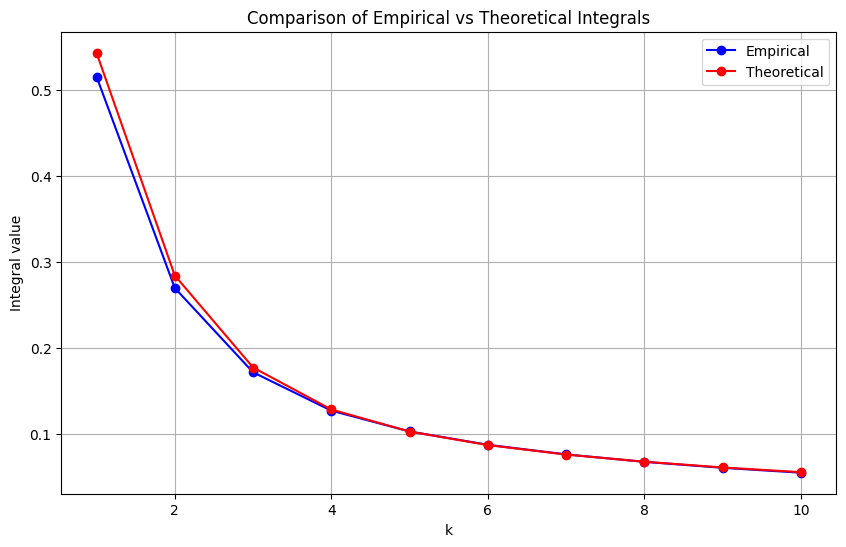

Empirical integrals: [0.5156301  0.26993024 0.17197104 0.12737398 0.10320283 0.08771536
 0.07653443 0.06788449 0.06094148 0.0552539 ]
Theoretical integrals: [0.54331523 0.28443164 0.17752004 0.12872301 0.10307129 0.08733494
 0.0763579  0.06801722 0.06135498 0.05587981]
Relative difference: [0.05095588 0.05098376 0.03125844 0.01048012 0.00127613 0.00435595
 0.00231183 0.00195145 0.00673941 0.01120091]


In [7]:
# Set parameters
v = 10000
d = 1000
alpha = 1.0
beta = 1.0

# Generate random matrix and get eigenvalues/eigenvectors
key = jax.random.PRNGKey(0)
W = jax.random.normal(key, (v, d)) / jnp.sqrt(d)

# Create D_sqrt as vector and multiply using broadcasting
D_sqrt = jnp.arange(1, v+1)**(-alpha)
DW = D_sqrt[:, None] * W

# Use SVD instead of forming K explicitly
U, S, _ = jnp.linalg.svd(DW, full_matrices=False)
eigenvals = S**2  # Singular values squared give eigenvalues
eigenvecs = U #[:, :d]  # Only need first d columns

# Compute weights c_i
b = jnp.arange(1, v+1)**(-beta)
Db = D_sqrt * b  # Element-wise multiplication
weights = jnp.array([(jnp.dot(eigenvecs[:,i], Db)**2)/eigenvals[i] for i in range(d)])

# Define test function f(x,k) = x*exp(-0.1*k*x)
def f(x, k):
    return jnp.sqrt(x)*jnp.exp(- k * x)

# Compute empirical integrals
k_vals = jnp.arange(1, 11)
empirical_integrals = jnp.array([jnp.sum(weights * f(eigenvals, k)) for k in k_vals])

# Compute theoretical integrals using density approximation
xs = jnp.linspace(0.0001, max(eigenvals)*1.1, 10000)
err = -10
batches = 1
zs = xs

density = jax_gen_trace_fmeasure(v, d, alpha, beta, zs, err=err, batches = batches)
dx = xs[1] - xs[0]
theoretical_integrals = jnp.array([jnp.sum(density * f(xs, k) * dx) for k in k_vals])

# Plot results
plt.figure(figsize=(10,6))
plt.plot(k_vals, empirical_integrals, 'bo-', label='Empirical')
plt.plot(k_vals, theoretical_integrals, 'ro-', label='Theoretical')
plt.xlabel('k')
plt.ylabel('Integral value')
plt.title('Comparison of Empirical vs Theoretical Integrals')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical values
print("Empirical integrals:", empirical_integrals)
print("Theoretical integrals:", theoretical_integrals)
print("Relative difference:", jnp.abs(empirical_integrals - theoretical_integrals)/theoretical_integrals)



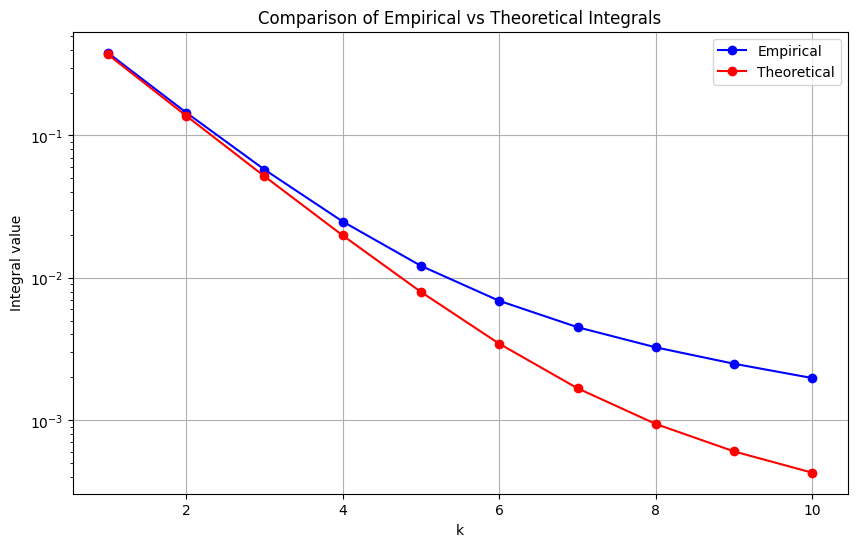

Empirical integrals: [0.3814859  0.14503485 0.05767228 0.02486748 0.01214182 0.00689451
 0.00450086 0.00324836 0.00249117 0.00197679]
Theoretical integrals: [0.37102294 0.13778333 0.05173339 0.01986095 0.00796074 0.00344497
 0.00167571 0.00094031 0.0006035  0.00042754]
Relative difference: [0.02820033 0.05262985 0.11479811 0.25207913 0.5252127  1.0013279
 1.6859362  2.4545662  3.1278791  3.6236188 ]


In [132]:
# Plot results
plt.figure(figsize=(10,6))
plt.plot(k_vals, empirical_integrals, 'bo-', label='Empirical')
plt.plot(k_vals, theoretical_integrals, 'ro-', label='Theoretical')
plt.xlabel('k')
plt.yscale('log')
plt.ylabel('Integral value')
plt.title('Comparison of Empirical vs Theoretical Integrals')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical values
print("Empirical integrals:", empirical_integrals)
print("Theoretical integrals:", theoretical_integrals)
print("Relative difference:", jnp.abs(empirical_integrals - theoretical_integrals)/theoretical_integrals)


In [130]:
# Set parameters and generate multiple runs
n_runs = 10
v = 10000
d = 4000
alpha = 1.0
beta = 1.0
k_vals = jnp.arange(1, 11)
xs = jnp.linspace(0.001, 2.0, 10000)
err = -10
batches = 1

# Store results from multiple runs
all_empirical_integrals = []
key = jax.random.PRNGKey(0)

# Generate multiple random matrices and compute their integrals
for i in tqdm(range(n_runs)):
    key, subkey = jax.random.split(key)
    
    # Generate random matrix and get eigenvalues/eigenvectors
    W = jax.random.normal(subkey, (v, d)) / jnp.sqrt(d)
    D_sqrt = jnp.arange(1, v+1)**(-alpha)
    DW = D_sqrt[:, None] * W
    U, S, _ = jnp.linalg.svd(DW, full_matrices=False)
    eigenvals = S**2
    eigenvecs = U
    
    # Compute weights
    b = jnp.arange(1, v+1)**(-beta)
    Db = D_sqrt * b
    weights = jnp.array([(jnp.dot(eigenvecs[:,i], Db)**2)/eigenvals[i] for i in range(d)])
    
    # Compute empirical integrals for this run
    empirical_integrals = jnp.array([jnp.sum(weights * f(eigenvals, k)) for k in k_vals])
    all_empirical_integrals.append(empirical_integrals)

# Convert to array for easier computation
all_empirical_integrals = jnp.array(all_empirical_integrals)

# Compute statistics
median = jnp.median(all_empirical_integrals, axis=0)
q25 = jnp.percentile(all_empirical_integrals, 25, axis=0)
q75 = jnp.percentile(all_empirical_integrals, 75, axis=0)

# Compute theoretical integrals
#density = jax_gen_trace_fmeasure(v, d, alpha, beta, xs, err=err, batches=batches)
#dx = xs[1] - xs[0]
#theoretical_integrals = jnp.array([jnp.sum(density * f(xs, k) * dx) for k in k_vals])

# Plot results with confidence interval
plt.figure(figsize=(10,6))
plt.fill_between(k_vals, q25, q75, alpha=0.3, color='blue', label='50% CI')
plt.plot(k_vals, median, 'bo-', label='Empirical Median')
plt.plot(k_vals, theoretical_integrals, 'ro-', label='Theoretical')
plt.xlabel('k')
plt.ylabel('Integral value')
plt.title('Comparison of Empirical vs Theoretical Integrals')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical values
print("Theoretical integrals:", theoretical_integrals)
print("Median empirical integrals:", median)
print("25th percentile:", q25)
print("75th percentile:", q75)

KeyboardInterrupt: 

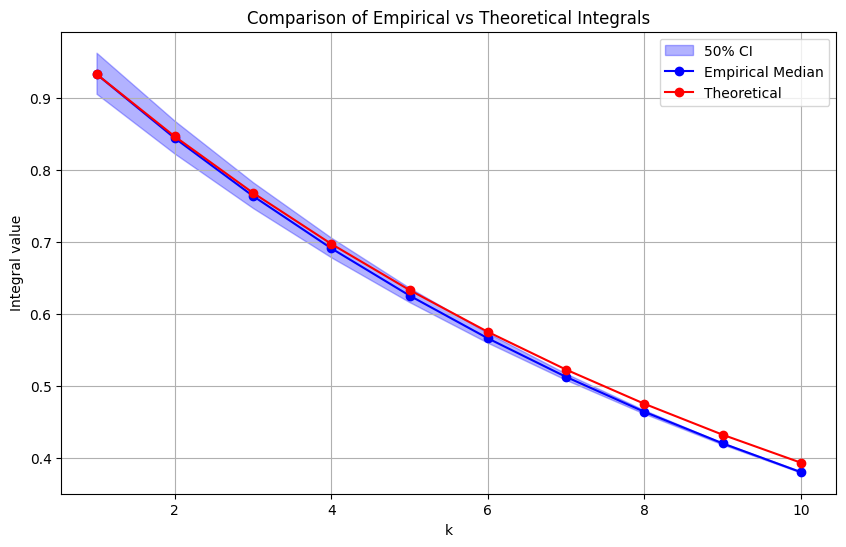

Theoretical integrals: [0.9100935  0.8235582  0.7452787  0.6744664  0.6104075  0.5524571
 0.50003165 0.4526035  0.4096956  0.37087604]
Median empirical integrals: [0.9326781  0.84380424 0.7634943  0.6909205  0.62533534 0.5660636
 0.5124956  0.4640802  0.4203199  0.38032556]
25th percentile: [0.90542674 0.82225204 0.74679375 0.67833465 0.6162235  0.55987024
 0.50828314 0.46139476 0.41867363 0.3796273 ]
75th percentile: [0.9623842  0.8677849  0.7825841  0.70562184 0.6360545  0.57344484
 0.51709455 0.46637568 0.42095786 0.38154978]


In [126]:
# Plot results with confidence interval
plt.figure(figsize=(10,6))
plt.fill_between(k_vals, q25, q75, alpha=0.3, color='blue', label='50% CI')
plt.plot(k_vals, median, 'bo-', label='Empirical Median')
plt.plot(k_vals, theoretical_integrals + (median[0] -theoretical_integrals[0]), 'ro-', label='Theoretical')
plt.xlabel('k')
plt.ylabel('Integral value')
plt.title('Comparison of Empirical vs Theoretical Integrals')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical values
print("Theoretical integrals:", theoretical_integrals)
print("Median empirical integrals:", median)
print("25th percentile:", q25)
print("75th percentile:", q75)

# # Testing the empirical density estimator

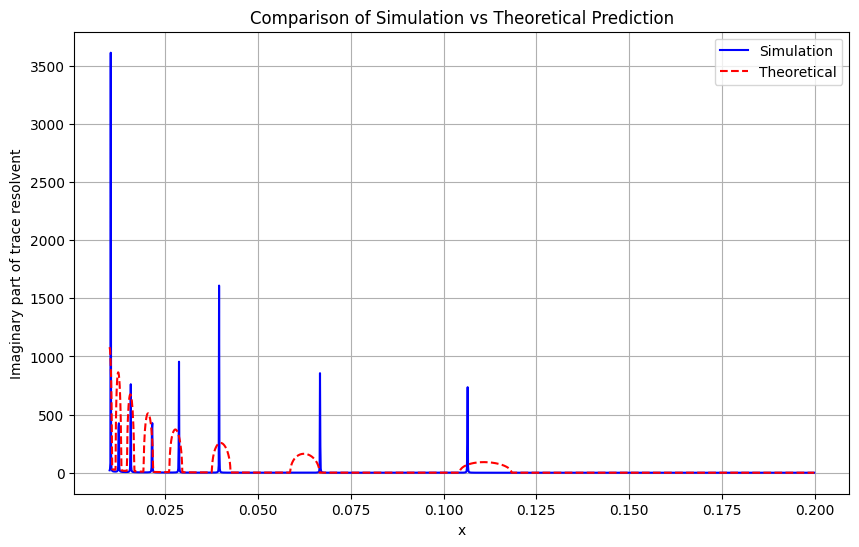

In [78]:
def generate_random_matrix_eigenvals(v, d, alpha, key):
    """Generate eigenvalues of K more efficiently using d x d matrix"""
    # Generate W with iid normal entries
    key, subkey = jax.random.split(key)
    W = jax.random.normal(subkey, (v, d)) / jnp.sqrt(d)
    
    # Generate D^(1/2) entries
    D_sqrt = jnp.arange(1, v+1)**(-alpha)
    
    # Multiply D^(1/2) with W directly using broadcasting
    DW = D_sqrt[:, None] * W
    
    # Form d x d matrix W^T D W instead of v x v matrix
    small_matrix = DW.T @ DW
    
    # Get eigenvalues of smaller matrix
    eigenvals = jnp.linalg.eigvalsh(small_matrix)
    
    return eigenvals
    # The v-d zero eigenvalues are implicit
    #return jnp.concatenate([eigenvals, jnp.zeros(v-d)])

# Set parameters
v = 10000  # Now we can use much larger v
d = 1000   # d can be smaller
alpha = 1.0
beta = 1.0
xs = jnp.arange(0.01, 0.2, 0.0001)
err = -6
epsilon = 10**err

# Generate eigenvalues
key = jax.random.PRNGKey(0)
eigenvals = generate_random_matrix_eigenvals(v, d, alpha, key)

# Compute trace resolvent using eigenvalues
def compute_trace_resolvent_eig(eigenvals, x, epsilon):
    z = x + 1j * epsilon
    return jnp.sum(1.0 / (eigenvals - z))

# Compute for all xs
tr_resolvent = jnp.array([compute_trace_resolvent_eig(eigenvals, x, epsilon) for x in xs])
imag_tr_resolvent = jnp.imag(tr_resolvent)

# Get theoretical prediction
theoretical = jax_gen_trace_trsolvent(v, d, alpha, beta, xs, err=err)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(xs, imag_tr_resolvent, 'b-', label='Simulation')
plt.plot(xs, theoretical, 'r--', label='Theoretical')
plt.xlabel('x')
plt.ylabel('Imaginary part of trace resolvent')
plt.title('Comparison of Simulation vs Theoretical Prediction')
plt.legend()
plt.grid(True)
plt.show()

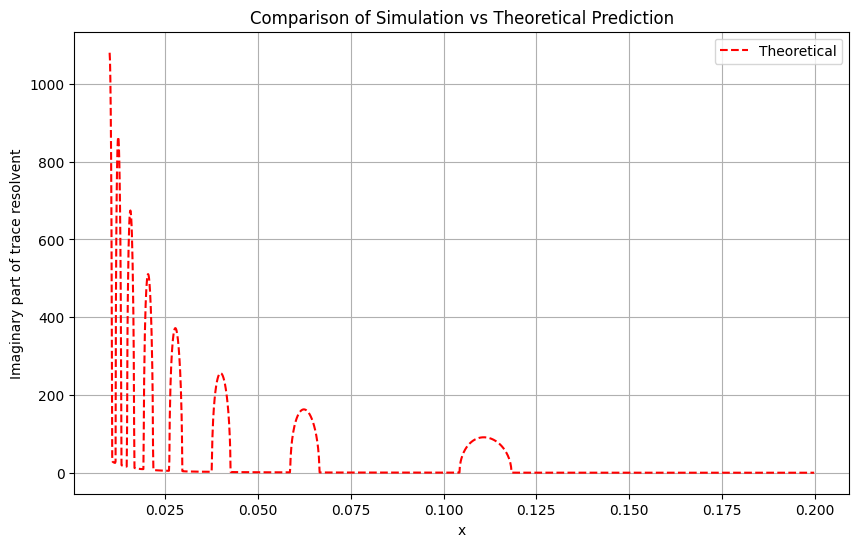

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(xs, theoretical, 'r--', label='Theoretical')
plt.xlabel('x')
plt.ylabel('Imaginary part of trace resolvent')
plt.title('Comparison of Simulation vs Theoretical Prediction')
plt.legend()
plt.grid(True)
plt.show()


Probability mass in interval [0.001, 0.025]:
Theoretical: 25.198086
Empirical:   25.000000


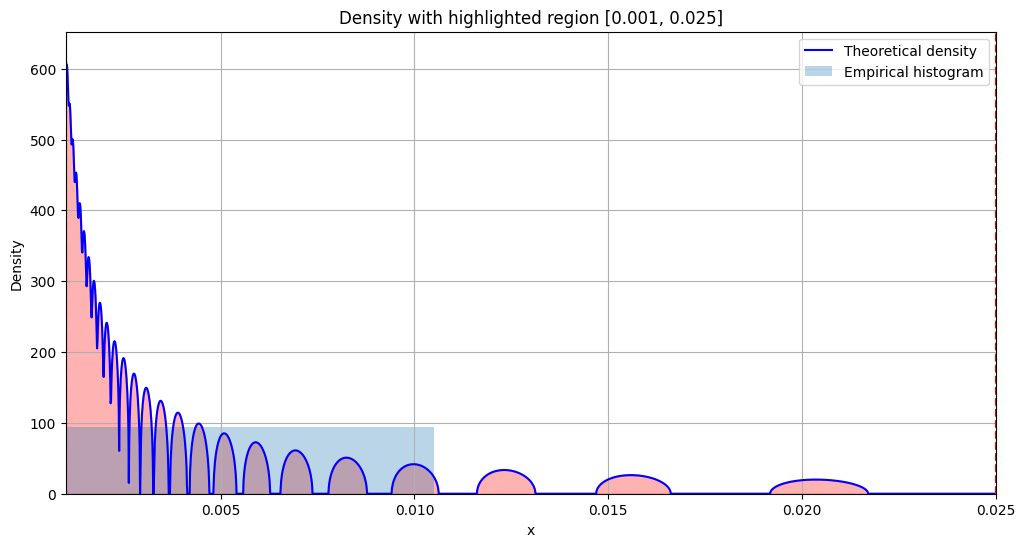

In [92]:
# Use finer grid for more accurate integration
a, b = 0.001, 0.025

xs = jnp.arange(a, b, 0.00001)
err = -10
epsilon = 10**(err)


# Generate theoretical density
theoretical = jax_gen_trace_trsolvent(v, d, alpha, beta, xs, err=err,batches=1)

# Generate eigenvalues
key = jax.random.PRNGKey(0)
eigenvals = generate_random_matrix_eigenvals(v, d, alpha, key)

# Compute integrals
def theoretical_integral(xs, density, a, b):
    # Normalize density to make it a probability measure
    dx = xs[1] - xs[0]
    #norm = jnp.sum(density) * dx
    #density = density / norm
    
    # Find indices corresponding to interval [a,b]
    idx = (xs >= a) & (xs <= b)
    integral = jnp.sum(density[idx]) * dx
    return float(integral)

def empirical_integral(eigenvals, a, b):
    count = jnp.sum((eigenvals >= a) & (eigenvals <= b))
    return float(count)

theoretical_mass = theoretical_integral(xs, theoretical, a, b)
empirical_mass = empirical_integral(eigenvals, a, b)

print(f"\nProbability mass in interval [{a}, {b}]:")
print(f"Theoretical: {theoretical_mass:.6f}")
print(f"Empirical:   {empirical_mass:.6f}")

# Let's also visualize this region
plt.figure(figsize=(12, 6))

# Plot full density
dx = xs[1] - xs[0]
norm = jnp.sum(theoretical) * dx
normalized_density = theoretical / norm

plt.plot(xs, normalized_density, 'b-', label='Theoretical density')

# Highlight the region of interest
idx = (xs >= a) & (xs <= b)
plt.fill_between(xs[idx], normalized_density[idx], alpha=0.3, color='red')

# Add histogram of eigenvalues
plt.hist(eigenvals, bins=100, density=True, alpha=0.3, label='Empirical histogram')

plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='r', linestyle='--')

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Density with highlighted region [{a}, {b}]')
plt.xlim(a, b)
plt.legend()
plt.grid(True)
plt.show()

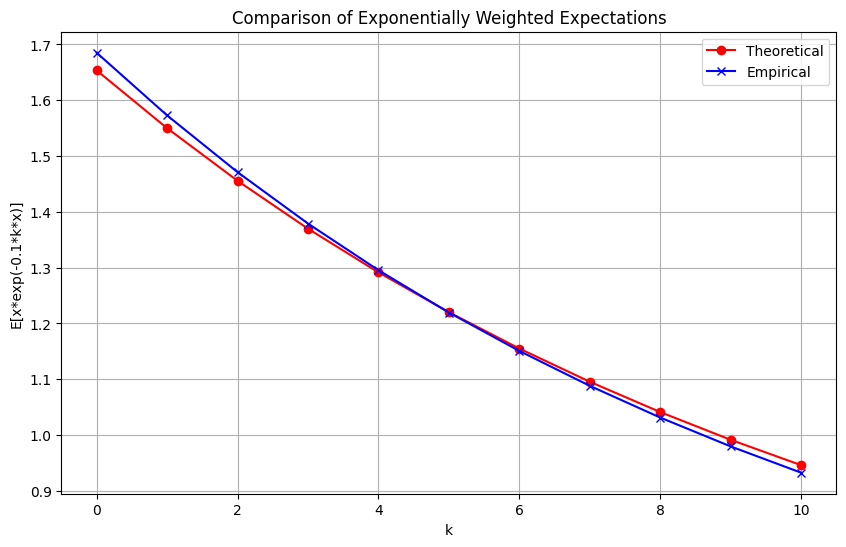


Exponentially weighted expectations comparison:
k	Theoretical	Empirical
0	1.653546	1.685170
1	1.549992	1.572892
2	1.455709	1.471186
3	1.369824	1.379013
4	1.291546	1.295432
5	1.220161	1.219601
6	1.155023	1.150757
7	1.095547	1.088215
8	1.041202	1.031358
9	0.991511	0.979631
10	0.946039	0.932531


In [88]:
# Extend x range to [0,2] for better coverage
xs = jnp.arange(0.00001, 2.0, 0.0001)
err = -10
epsilon = 10**(err)


# Generate theoretical density
theoretical = jax_gen_trace_trsolvent(v, d, alpha, beta, xs, err=err, batches=1)

# Generate eigenvalues
key = jax.random.PRNGKey(0)
eigenvals = generate_random_matrix_eigenvals(v, d, alpha, key)

# Compute weighted expectations
def compute_theoretical_exp_weights(xs, density, k_values):
    # Normalize density to make it a probability measure
    dx = xs[1] - xs[0]
    density = density 
    # norm = jnp.sum(density) * dx
    # density = density / norm
    
    expectations = []
    for k in k_values:
        weight_func = xs * jnp.exp(-0.1 * k * xs)
        expectation = jnp.sum(weight_func * density) * dx
        expectations.append(float(expectation))
    return expectations

def compute_empirical_exp_weights(eigenvals, k_values):
    expectations = []
    for k in k_values:
        weight_func = eigenvals * jnp.exp(-0.1 * k * eigenvals)
        expectation = jnp.sum(weight_func)
        expectations.append(float(expectation))
    return expectations

k_values = range(11)  # 0 to 10
theoretical_exp = compute_theoretical_exp_weights(xs, theoretical, k_values)
empirical_exp = compute_empirical_exp_weights(eigenvals, k_values)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(k_values, theoretical_exp, 'ro-', label='Theoretical')
plt.plot(k_values, empirical_exp, 'bx-', label='Empirical')
plt.xlabel('k')
plt.ylabel('E[x*exp(-0.1*k*x)]')
plt.title('Comparison of Exponentially Weighted Expectations')
plt.legend()
plt.grid(True)
plt.show()

# Print the values
print("\nExponentially weighted expectations comparison:")
print("k\tTheoretical\tEmpirical")
for k in k_values:
    print(f"{k}\t{theoretical_exp[k]:.6f}\t{empirical_exp[k]:.6f}")

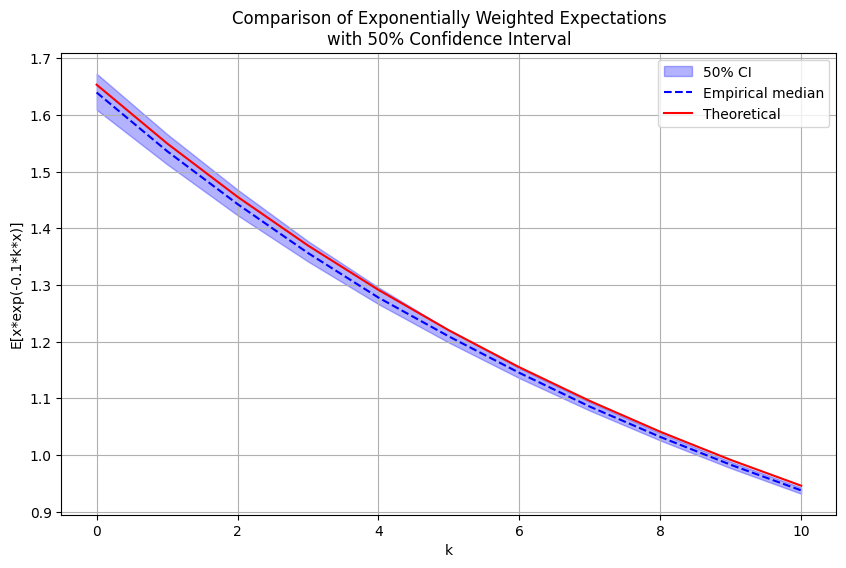


Statistics for k=0,1,2:
k	Theoretical	Median		25th		75th
0	1.653546	1.639816	1.609353	1.672922
1	1.549992	1.536366	1.513139	1.566432
2	1.455709	1.442921	1.423202	1.468400


In [91]:
n_runs = 100
k_values = range(11)

# Generate multiple runs of eigenvalues and their expectations
key = jax.random.PRNGKey(0)
all_empirical_exp = []

for i in range(n_runs):
    key, subkey = jax.random.split(key)
    eigenvals = generate_random_matrix_eigenvals(v, d, alpha, subkey)
    exp_weights = compute_empirical_exp_weights(eigenvals, k_values)
    all_empirical_exp.append(exp_weights)

# Convert to array for easier computation
all_empirical_exp = jnp.array(all_empirical_exp)

# Compute median and quartiles
median = jnp.median(all_empirical_exp, axis=0)
q25 = jnp.percentile(all_empirical_exp, 25, axis=0)
q75 = jnp.percentile(all_empirical_exp, 75, axis=0)

# Plot
plt.figure(figsize=(10, 6))

# Plot confidence interval
plt.fill_between(k_values, q25, q75, alpha=0.3, color='blue', label='50% CI')

# Plot median of simulations
plt.plot(k_values, median, 'b--', label='Empirical median')

# Plot theoretical curve
plt.plot(k_values, theoretical_exp, 'r-', label='Theoretical')

plt.xlabel('k')
plt.ylabel('E[x*exp(-0.1*k*x)]')
plt.title('Comparison of Exponentially Weighted Expectations\nwith 50% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

# Print some statistics
print("\nStatistics for k=0,1,2:")
print("k\tTheoretical\tMedian\t\t25th\t\t75th")
for k in range(3):
    print(f"{k}\t{theoretical_exp[k]:.6f}\t{median[k]:.6f}\t{q25[k]:.6f}\t{q75[k]:.6f}")

In [67]:
for k in k_values:
    print(f"{k}\t{theoretical_exp[k]:.6f}\t{empirical_exp[k]:.6f}")

0	0.000326	0.001685
1	0.000309	0.001573
2	0.000294	0.001471
3	0.000281	0.001379
4	0.000268	0.001295
5	0.000257	0.001220
6	0.000247	0.001151
7	0.000237	0.001088
8	0.000228	0.001031
9	0.000220	0.000980
10	0.000213	0.000933


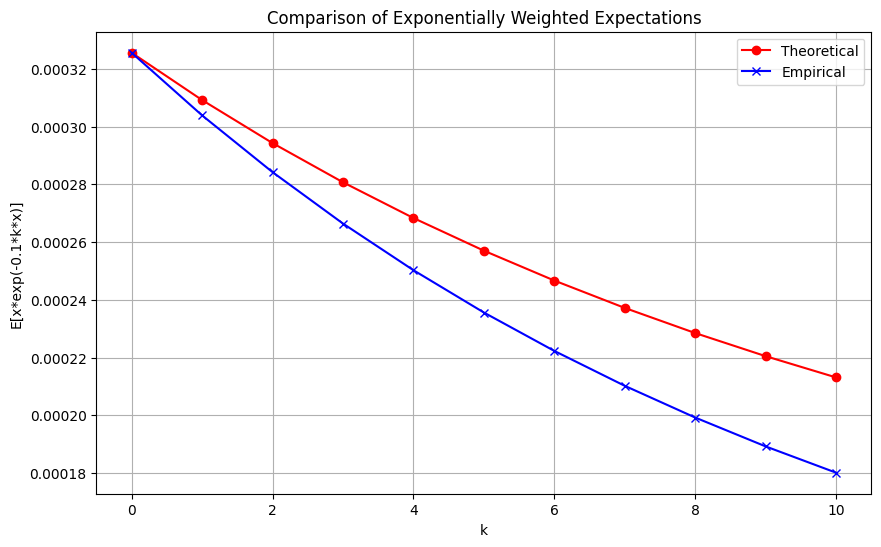

In [68]:
# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(k_values, theoretical_exp, 'ro-', label='Theoretical')
plt.plot(k_values, jnp.array(empirical_exp)*(theoretical_exp[0]/empirical_exp[0]), 'bx-', label='Empirical')
plt.xlabel('k')
plt.ylabel('E[x*exp(-0.1*k*x)]')
plt.title('Comparison of Exponentially Weighted Expectations')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
jnp.array(empirical_exp)*(theoretical_exp[0]/empirical_exp[0])

Array([0.00032555, 0.00030386, 0.00028421, 0.0002664 , 0.00025026,
       0.00023561, 0.00022231, 0.00021023, 0.00019924, 0.00018925,
       0.00018015], dtype=float32)

In [70]:
theoretical_exp[0]/empirical_exp[0]

0.1931837493442369

In [60]:
v

1000